In [1]:
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
import scanpy.external as sce
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

input_csv = f'{res_dir}noHarmony_March30_v4_isocortex_hpf.csv'
print(input_csv)

output_csv = f'{res_dir}Joint_UMAP_isocortex_hpf_April14.csv'
output2_csv = f'{res_dir}Joint_UMAP_isocortex_hpf_subsamp100_level1_April14.csv'
print(output_csv)
print(output2_csv)

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'

# allen tree
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'


/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/noHarmony_March30_v4_isocortex_hpf.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_April14.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_subsamp100_level1_April14.csv


In [4]:
%%time
# results
dftypes = pd.read_csv(input_csv, index_col=0)
dftypes = dftypes.filter(regex=r'^Level_[0-9]', axis=1)
levels = dftypes.columns.values

# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
data.obs = data.obs.join(dftypes)

# print(data)
    
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)

# allen tree
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)

# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)


from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 805 ms, sys: 112 ms, total: 917 ms
Wall time: 914 ms


In [5]:
ref_data.obs = ref_data.obs.rename({
                                    'class_label': 'Level_1_class_label',
                                    'neighborhood_label': 'Level_2_neighborhood_label',
                                    'subclass_label': 'Level_3_subclass_label',
                                    'cluster_label': 'Level_5_cluster_label',
                                    }, axis=1)
ref_data

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

In [6]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
data = data[cond_cells]
data

View of AnnData object with n_obs × n_vars = 44075 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym', 'Level_1_class_label', 'Level_2_neighborhood_label', 'Level_3_subclass_label'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [7]:
def get_umap(Xcell, Ycell, 
             Xidx, Yidx, 
             Xname, Yname,
             **kwargs):
    """
    """
    # run UMAP
    embed = umap.UMAP(**kwargs).fit_transform(
        np.vstack([Xcell, Ycell])
        )

    dfembed = pd.DataFrame(index=np.hstack([Xidx, Yidx])) 
    dfembed['dataset'] = [Xname]*len(Xidx) + [Yname]*len(Yidx) 
    dfembed['embed_1'] = embed[:,0]
    dfembed['embed_2'] = embed[:,1]
    
    return dfembed 

In [8]:

Xname = 'scRNA-seq'
Yname = 'dredFISH'
X = ref_data.X/ref_data.X.sum(axis=1).reshape(-1,1)
Y = data.layers['norm_cell']
# level = 'Level_1_class_label'
# n = 100

# dfsub, xidx = basicu.stratified_sample(ref_data.obs, level, n, return_idx=True)
# Xcell = basicu.zscore(X[xidx], axis=0)
Xcell = X # basicu.zscore(X, axis=0)
Ycell = Y # basicu.zscore(Y, axis=0)

Xcell.shape, Ycell.shape

((73347, 24), (44075, 24))

In [9]:
obs_df = pd.DataFrame(index=np.hstack([
    ref_data.obs.index, 
    data.obs.index, 
    ]))
obs_df['dataset'] = [Xname]*len(Xcell) + [Yname]*len(Ycell) 

adata_merged = anndata.AnnData(
    X=np.vstack([Xcell,Ycell]),
    obs=obs_df,
)
adata_merged.obsm['features'] = np.vstack([
    Xcell - Xcell.mean(axis=0).reshape(1,-1),
    Ycell - Ycell.mean(axis=0).reshape(1,-1),
])
adata_merged

AnnData object with n_obs × n_vars = 117422 × 24
    obs: 'dataset'
    obsm: 'features'

```
def run_harmony(
    data_mat: np.ndarray,
    meta_data: pd.DataFrame,
    vars_use,
    theta = None,
    lamb = None,
    sigma = 0.1, 
    nclust = None,
    tau = 0,
    block_size = 0.05, 
    max_iter_harmony = 10,
    max_iter_kmeans = 20,
    epsilon_cluster = 1e-5,
    epsilon_harmony = 1e-4, 
    plot_convergence = False,
    verbose = True,
    reference_values = None,
    cluster_prior = None,
    random_state = 0
):
    """Run Harmony.
    """

    # theta = None
    # lamb = None
    # sigma = 0.1
    # nclust = None
    # tau = 0
    # block_size = 0.05
    # epsilon_cluster = 1e-5
    # epsilon_harmony = 1e-4
    # plot_convergence = False
    # verbose = True
    # reference_values = None
    # cluster_prior = None
    # random_state = 0
```

In [10]:
%%time

kwargs = dict(verbose=True)
sce.pp.harmony_integrate(adata_merged, 'dataset', 
                         basis='features', 
                         adjusted_basis='harmony',
                         **kwargs,
                        )



2022-04-14 14:01:11,556 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2022-04-14 14:02:25,255 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2022-04-14 14:03:37,593 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2022-04-14 14:04:59,388 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2022-04-14 14:06:14,507 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2022-04-14 14:07:30,905 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2022-04-14 14:08:45,228 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2022-04-14 14:10:01,118 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2022-04-14 14:11:21,895 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Converged after 8 iterations


CPU times: user 4h 42s, sys: 15min 56s, total: 4h 16min 39s
Wall time: 10min 45s


In [11]:

# 
Xcell_adj = adata_merged[adata_merged.obs['dataset']=='scRNA-seq'].obsm['harmony']
Ycell_adj = adata_merged[adata_merged.obs['dataset']=='dredFISH'].obsm['harmony']
print(Xcell_adj.shape, Ycell_adj.shape)

(73347, 24) (44075, 24)


In [12]:
# pause here

In [13]:
%%time

Xcell_adj = adata_merged[adata_merged.obs['dataset']=='scRNA-seq'].obsm['harmony']
Ycell_adj = adata_merged[adata_merged.obs['dataset']=='dredFISH'].obsm['harmony']
print(Xcell_adj.shape, Ycell_adj.shape)

dfembed = get_umap(Xcell_adj, Ycell_adj, 
                   ref_data.obs.index.values,
                   data.obs.index.values,
                   'scRNA-seq', 'dredFISH',
                   metric='correlation',
                   verbose=True,
                 )
output2_csv = f'{res_dir}Joint_UMAP_cellnorm_harmony_correlation_April14.csv'
print(output2_csv)
dfembed.to_csv(output2_csv, index=True, header=True)
dfembed

(73347, 24) (44075, 24)
UMAP(angular_rp_forest=True, metric='correlation', verbose=True)
Thu Apr 14 14:11:22 2022 Construct fuzzy simplicial set
Thu Apr 14 14:11:22 2022 Finding Nearest Neighbors
Thu Apr 14 14:11:22 2022 Building RP forest with 22 trees
Thu Apr 14 14:11:22 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Thu Apr 14 14:11:43 2022 Finished Nearest Neighbor Search
Thu Apr 14 14:11:47 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Apr 14 14:13:54 2022 Finished embedding
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_cellnorm_harmony_correlation_April14.csv
CPU times: user 1h 41min, sys: 1min 27s, total: 1h 42min 28s
Wall time: 2min 32s


,dataset,embed_1,embed_2
US-1250273_E1_S37,scRNA-seq,9.537591,9.757018
US-1250273_E2_S01,scRNA-seq,9.110587,9.906038
US-1250273_E2_S02,scRNA-seq,8.808782,10.092300
US-1250273_E2_S03,scRNA-seq,9.762882,3.821777
US-1250273_E2_S04,scRNA-seq,10.164116,2.900209
...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,dredFISH,-4.366783,9.858996
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,dredFISH,-2.626399,5.314900
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,dredFISH,-2.430597,5.202250
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,dredFISH,-2.533988,5.767023


In [14]:
dfembed

,dataset,embed_1,embed_2
US-1250273_E1_S37,scRNA-seq,9.537591,9.757018
US-1250273_E2_S01,scRNA-seq,9.110587,9.906038
US-1250273_E2_S02,scRNA-seq,8.808782,10.092300
US-1250273_E2_S03,scRNA-seq,9.762882,3.821777
US-1250273_E2_S04,scRNA-seq,10.164116,2.900209
...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,dredFISH,-4.366783,9.858996
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,dredFISH,-2.626399,5.314900
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,dredFISH,-2.430597,5.202250
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,dredFISH,-2.533988,5.767023


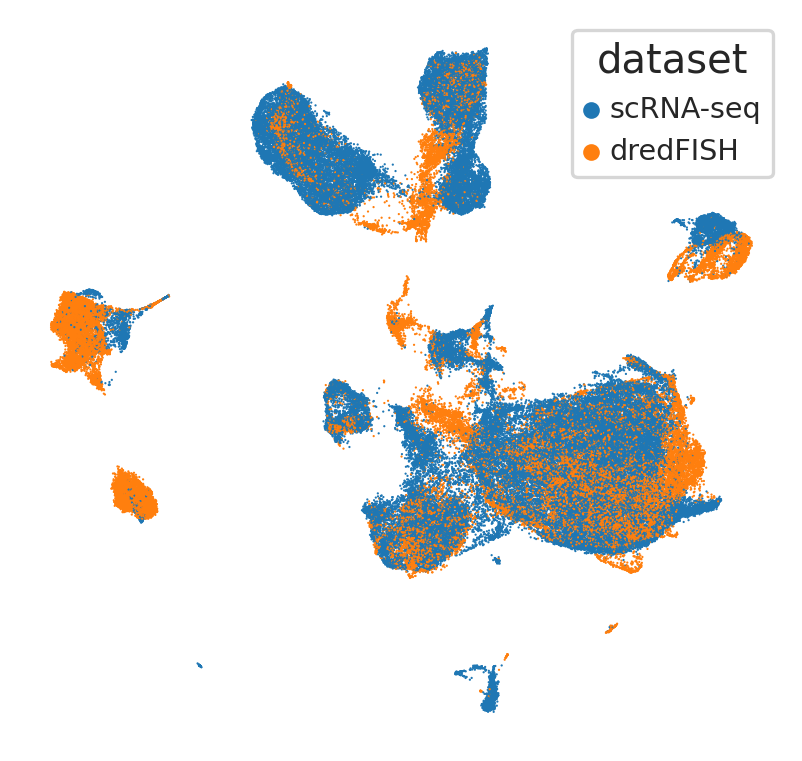

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=dfembed.sample(frac=1), 
                x='embed_1', y='embed_2', hue='dataset',
                s=1, 
                edgecolor="none",
               )
ax.axis('off')
ax.set_aspect('equal')
plt.show()